In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

The following code establishes a connection to an SQLite database named hawaii.sqlite. The script utilizes SQLAlchemy, a  Object Relational Mapper (ORM) library, which enables interaction with the database.  Once these components are established, users can perform various operations, such as querying the data or updating records, using the session object and the table references.

The create_engine function is called to establish a connection to the SQLite database file hawaii.sqlite, located in the ../Resources/ directory relative to the script's location.

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

The automap_base function is invoked to create a new automap base, which serves as the foundation for reflecting the database schema into Python classes.

In [17]:
# reflect an existing database into a new model
base = automap_base()

The prepare method is called on the automap base, passing the engine and reflect=True as arguments. This reflects the database tables into the automap base, generating Python class mappings for the tables in the database.

In [18]:
# reflect the tables
base.prepare(engine, reflect=True)

The keys method is called on the base.classes object to retrieve the table names found by automap, which in this case are 'measurement' and 'station'.

In [19]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

References to each table (measurement and station) are saved in the t_measurement and t_station variables, respectively. These references will be used for querying and interacting with the database.

In [20]:
# Save references to each table
t_measurement = base.classes.measurement
t_station = base.classes.station

A new session is created using the Session class and the engine. The session serves as a link between Python and the SQLite database, allowing for data queries and manipulation.

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
most_recent_date_result = session.query(func.max(t_measurement.date)).one()
# Extract the date from the result
most_recent_date = most_recent_date_result[0]

print("Most recent date in the data set:", most_recent_date)

Most recent date in the data set: 2017-08-23


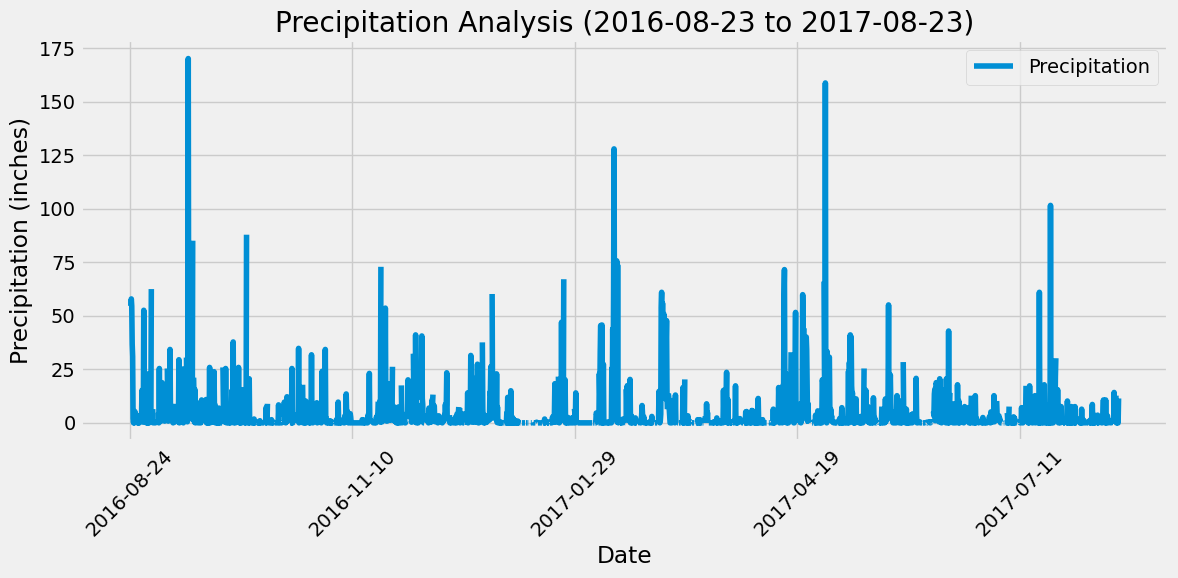

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set
one_year_ago = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(t_measurement.date, t_measurement.prcp).filter(t_measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])
precipitation_df.set_index("date", inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title(f"Precipitation Analysis ({one_year_ago.strftime('%Y-%m-%d')} to {most_recent_date})")
plt.xticks(rotation=45)
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
print(summary_statistics)

       precipitation
count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(t_station.station)).scalar()
print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [26]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
most_active_stations = session.query(t_measurement.station, func.count(t_measurement.station)).\
    group_by(t_measurement.station).\
    order_by(func.count(t_measurement.station).desc()).\
    all()
# List the stations and the counts in descending order.
print("Most active stations (in descending order):")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Most active stations (in descending order):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
most_active_station_id

'USC00519281'

In [29]:
lowest_temp, highest_temp, avg_temp = session.query(
    func.min(t_measurement.tobs),
    func.max(t_measurement.tobs),
    func.avg(t_measurement.tobs)
).filter(t_measurement.station == most_active_station_id).one()

print(f"Most active station ID: {most_active_station_id}")
print(f"Lowest temperature: {lowest_temp}")
print(f"Highest temperature: {highest_temp}")
print(f"Average temperature: {avg_temp:.2f}")

Most active station ID: USC00519281
Lowest temperature: 12.2
Highest temperature: 29.4
Average temperature: 22.04


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [30]:
tobs_data = session.query(t_measurement.tobs).\
    filter(t_measurement.station == most_active_station_id).\
    filter(t_measurement.date >= one_year_ago).\
    all()

In [31]:
tobs_df = pd.DataFrame(tobs_data, columns=["tobs"])

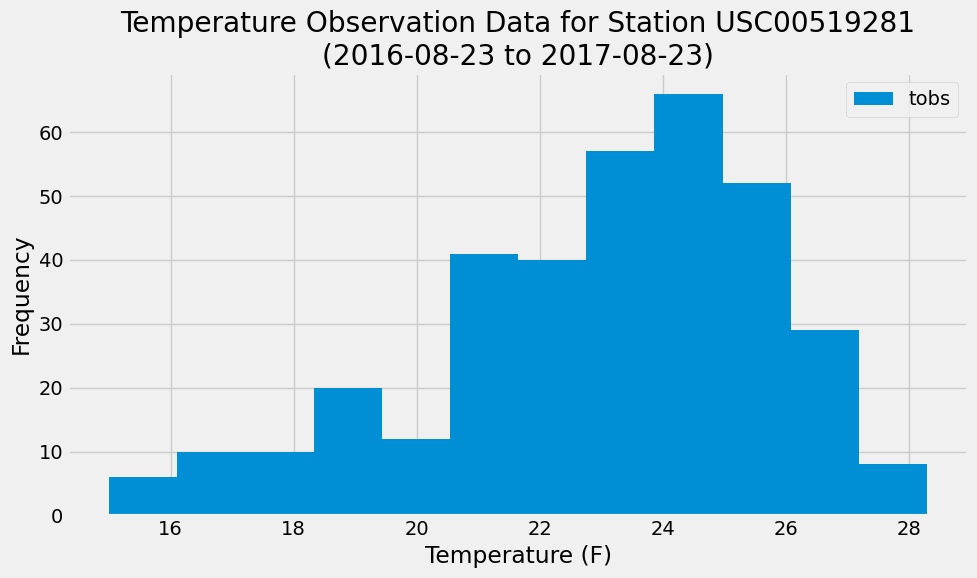

In [34]:
# Plot the results as a histogram
tobs_df.plot.hist(bins=12, figsize=(10, 6))
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observation Data for Station {most_active_station_id}\n({one_year_ago.strftime('%Y-%m-%d')} to {most_recent_date})")
plt.legend(["tobs"])
plt.tight_layout()
plt.savefig("../Images/Temp-obs-data.png")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()